In [1]:
# Import Libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


In [2]:
# Load and Preprocess Data
dfa = pd.read_csv('weather.csv')
dfb = pd.read_csv('emission.csv')

# Converting 'time' and 'FORMATTED_DATE' to datetime
dfa['time'] = pd.to_datetime(dfa['time'])
dfb['FORMATTED_DATE'] = pd.to_datetime(dfb['FORMATTED_DATE'])

# Setting 'time' and 'FORMATTED_DATE' as the index
dfa.set_index('time', inplace=True)
dfb.set_index('FORMATTED_DATE', inplace=True)

# Merging the dataframes on index
data = pd.merge(dfa, dfb, left_index=True, right_index=True, how='outer')

# Include selected features
data = data[['tavg', 'SO2_EMISSION', 'NO2_EMISSION']]

# Handle missing values & Normalize the data
data.fillna(data.mean(), inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Display the first few rows of the scaled data to verify
scaled_data[:5]


array([[0.48130195, 0.18283963, 0.09511435],
       [0.48130195, 0.41062308, 0.10914761],
       [0.48130195, 1.        , 0.56600832],
       [0.48130195, 0.1113381 , 0.15956341],
       [0.48130195, 0.06952207, 0.1188275 ]])

In [3]:
# Prepare the Dataset
def create_dataset(dataset, look_back=30):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back)])
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)

look_back = 30
X, y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))


In [4]:
# Build and Compile the LSTM Model
model = Sequential([
    Input(shape=(look_back, X.shape[2])),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3)
])

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error')


In [5]:
# Implement Callbacks for Early Stopping and Learning Rate Reduction
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the Model with Callbacks
history = model.fit(X, y, batch_size=32, epochs=100, validation_split=0.2, callbacks=[early_stop, reduce_lr])


Epoch 1/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - loss: 0.0138 - val_loss: 0.0016 - learning_rate: 5.0000e-04
Epoch 2/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0037 - val_loss: 0.0014 - learning_rate: 5.0000e-04
Epoch 3/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0032 - val_loss: 0.0013 - learning_rate: 5.0000e-04
Epoch 4/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0030 - val_loss: 0.0013 - learning_rate: 5.0000e-04
Epoch 5/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0029 - val_loss: 0.0011 - learning_rate: 5.0000e-04
Epoch 6/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0027 - val_loss: 0.0011 - learning_rate: 5.0000e-04
Epoch 7/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - loss: 0.0026 - val_loss: 9.4508e-04 - learning_rate: 5.0000e-04
Epoch 8/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.0027 - val_loss: 9.4558e-04 - learning_rate: 5.0000e-04
Epoch 9/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step -

In [6]:
# Prepare Test Data (last sequence of 2024)
X_test = np.expand_dims(scaled_data[-look_back:], axis=0)

# Forecast Function
def forecast(model, start_sequence, days_to_predict):
    forecasted = []
    current_sequence = start_sequence
    for _ in range(days_to_predict):
        pred = model.predict(current_sequence, verbose=0)
        forecasted.append(pred[0])
        current_sequence = np.append(current_sequence[:, 1:, :], np.expand_dims(pred, axis=1), axis=1)
    return forecasted

days_to_predict = 7
predicted_2025 = forecast(model, X_test, days_to_predict)
predicted_2025 = scaler.inverse_transform(np.array(predicted_2025).reshape(-1, 3))


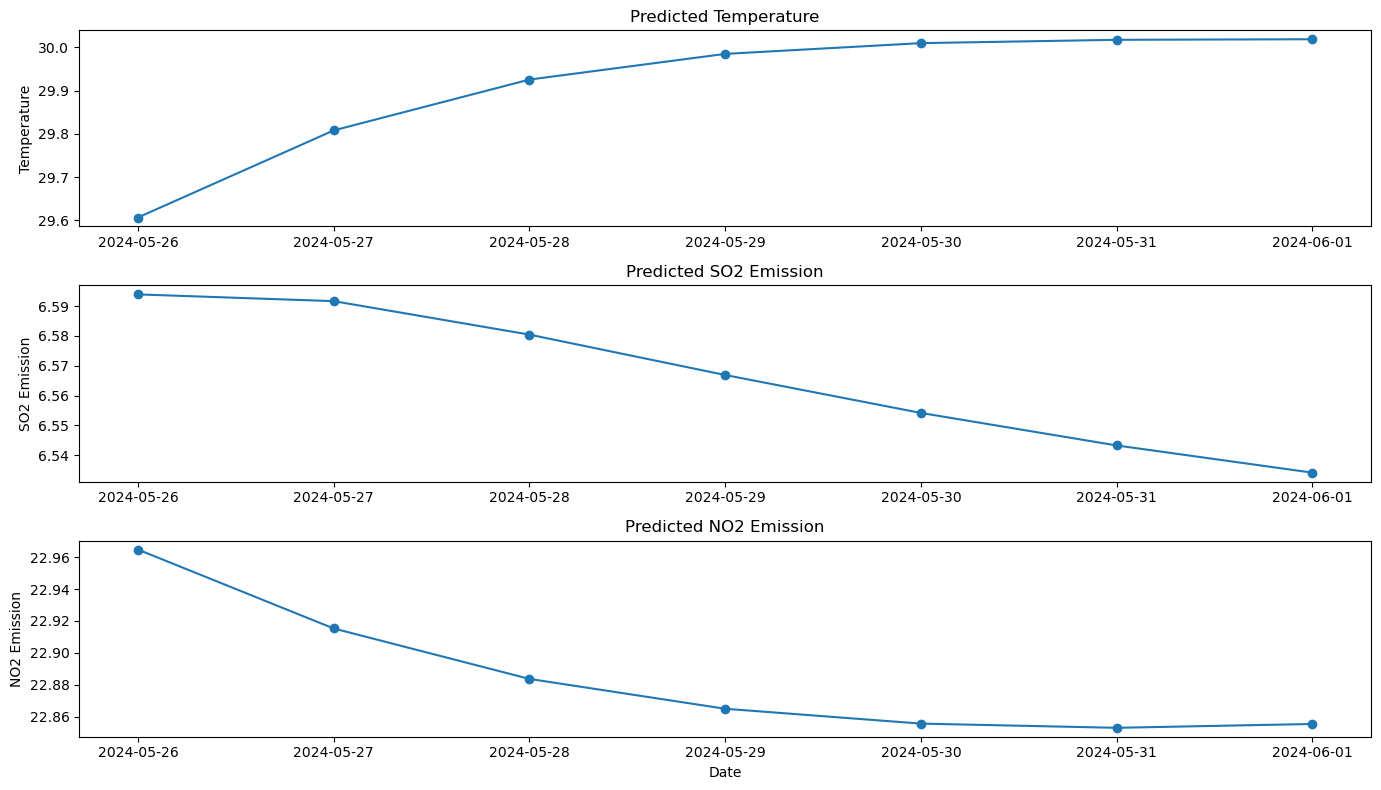

In [7]:
# Create a DataFrame with Dates and Predicted Values
start_date = datetime(2024, 5, 26)
date_list = [start_date + timedelta(days=x) for x in range(days_to_predict)]
predicted_df = pd.DataFrame({
    'Date': date_list,
    'Predicted_Temperature': predicted_2025[:, 0],
    'Predicted_SO2_Emission': predicted_2025[:, 1],
    'Predicted_NO2_Emission': predicted_2025[:, 2]
})

# Visualization of the Predictions
plt.figure(figsize=(14, 8))

# Predicted Temperature  
plt.subplot(3, 1, 1)
plt.plot(predicted_df['Date'], predicted_df['Predicted_Temperature'], marker='o')
plt.title('Predicted Temperature')
plt.ylabel('Temperature')

# SO2 Emission
plt.subplot(3, 1, 2)
plt.plot(predicted_df['Date'], predicted_df['Predicted_SO2_Emission'], marker='o')
plt.title('Predicted SO2 Emission')
plt.ylabel('SO2 Emission')

# NO2 Emission
plt.subplot(3, 1, 3)
plt.plot(predicted_df['Date'], predicted_df['Predicted_NO2_Emission'], marker='o')
plt.title('Predicted NO2 Emission')
plt.ylabel('NO2 Emission')
plt.xlabel('Date')
plt.tight_layout()
plt.show()
